## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

* https://github.com/gastonstat/CreditScoring

* Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 15:34:03--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.03s   

2021-10-03 15:34:04 (5.78 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation
We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [4]:
df

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,2,1,1,60,39,2,1,1,69,92,0,0,900,1020
4451,1,22,2,60,46,2,1,1,60,75,3000,600,950,1263
4452,2,0,2,24,37,2,1,2,60,90,3500,0,500,963
4453,1,0,1,48,23,1,1,3,49,140,0,0,550,550


Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [9]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


## Your code

What are the categorical variables? What are the numerical?

In [10]:
print(f'Categorical variables: {list(df.select_dtypes(include="object").columns)}')
print(f'Numerical variables: {list(df.select_dtypes(exclude="object").columns)}')

Categorical variables: ['home', 'marital', 'records', 'job']
Numerical variables: ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [11]:
from sklearn.model_selection import train_test_split

full_train, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(full_train, test_size=0.25, random_state=1)
len(train), len(val), len(test)

(2672, 891, 891)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [12]:
from sklearn.metrics import roc_auc_score

for col in df.drop("default", axis=1).select_dtypes(exclude="object").columns:
    auc_score = roc_auc_score(train.default, train[col])
    if auc_score < 0.5:
        auc_score = roc_auc_score(train.default, -train[col])
    print(f'{col:<10}: {auc_score:.4f}')

seniority : 0.7094
time      : 0.5609
age       : 0.5733
expenses  : 0.5009
income    : 0.6820
assets    : 0.6486
debt      : 0.5048
amount    : 0.5911
price     : 0.5043


Which numerical variable (among the following 4) has the highest AUC?

* seniority
* time
* income
* debt

## Training the model

From now on, use these columns only:

    ['seniority', 'income', 'assets', 'records', 'job', 'home']
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Apply one-hot-encoding using DictVectorizer
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv = DictVectorizer(sparse=False)

train_dict = train[features].to_dict(orient='records')
val_dict = val[features].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

y_train = train.default
y_val = val.default

# train the logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# get probabilities on validation dataset
predictions = model.predict_proba(X_val)[:, 1]

In [14]:
# function to get TPR (recall), FPR scores
# for a given range of thresholds

def tpr_fpr_dataframe(y_val, y_pred, thresholds):
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
        
    return df_scores

In [15]:
thresholds = np.arange(0, 1.01, 0.01)
df_scores = tpr_fpr_dataframe(y_val, predictions, thresholds)
df_scores.loc[df_scores.threshold == 0.5, :]

,threshold,tp,fp,fn,tn,tpr,fpr
50,0.5,114,64,132,581,0.463415,0.099225


In [16]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
print(num_neg, num_pos)
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal_pred = np.linspace(0, 1, len(y_val))
print(1 - y_val.mean())
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred, thresholds)

645 246
0.7239057239057238


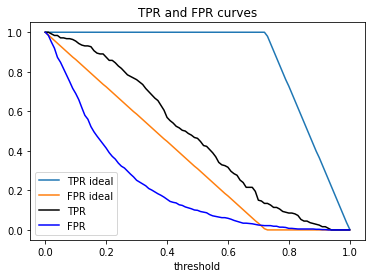

In [17]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')
plt.xlabel('threshold')
plt.title('TPR and FPR curves')
plt.legend()

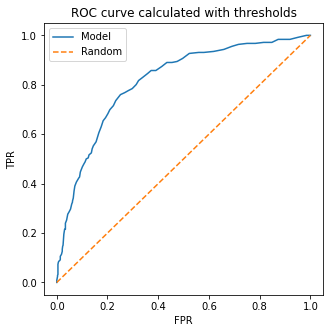

In [18]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve calculated with thresholds')
plt.legend()

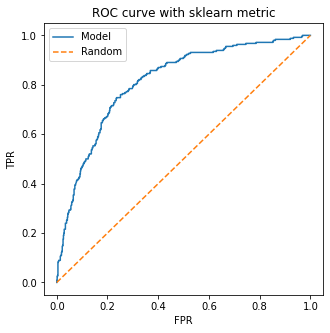

In [19]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(y_val, predictions)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve with sklearn metric')
plt.legend()

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.512
* 0.612
* 0.712
* 0.812

In [20]:
# ROC-AUC with predictions and `roc_auc_score` metric
auc_score = roc_auc_score(y_val, predictions)
round(auc_score, 3)

0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [21]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)

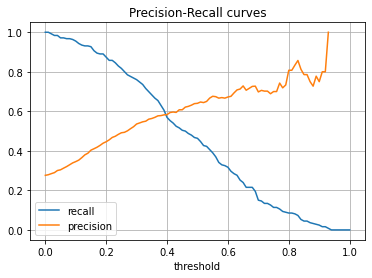

In [22]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='recall')
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.xlabel('threshold')
plt.title('Precision-Recall curves')
plt.grid()
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

In [23]:
# find threshold at which precision and recall curves intersect
df_scores.iloc[(df_scores['precision'] - df_scores['tpr']).abs().argmin(), 0]

0.4

## Quesiton 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01


In [24]:
df_scores['f1'] = 2 * (df_scores.precision * df_scores.tpr)/(df_scores.precision + df_scores.tpr)

At which threshold F1 is maximal?

* 0.1
* 0.3
* 0.5
* 0.7

In [25]:
print(df_scores.iloc[df_scores['f1'].argmax(), :])

threshold      0.300000
tp           187.000000
fp           162.000000
fn            59.000000
tn           483.000000
tpr            0.760163
fpr            0.251163
precision      0.535817
f1             0.628571
Name: 30, dtype: float64


In [26]:
df_scores.iloc[df_scores['f1'].argmax(), 0]

0.3

In [27]:
from sklearn.metrics import precision_recall_curve

# function to determine the best threshold
def find_best_threshold(y_true, y_prob):
    """Find the best threshold for maximum F1."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1s = (2 * precisions * recalls) / (precisions + recalls)
    return thresholds[np.argmax(f1s)]

# Best threshold for f1
threshold = find_best_threshold(y_val, predictions)
print(f'Best threshold maximizing F1 score: {threshold:.4f}')

Best threshold maximizing F1 score: 0.3162


## Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

    KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

In [28]:
from sklearn.model_selection import KFold

scores = list()

# Use the KFold class from Scikit-Learn
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Iterate over different folds of `full_train`
for fold, (train_idx, val_idx) in enumerate(kfold.split(full_train)):
        
        # Split the data into train and validation
        df_train = full_train.iloc[train_idx]
        df_val = full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values
        
        # Apply one-hot-encoding using DictVectorizer
        train_dict = df_train[features].to_dict(orient='records')
        val_dict = df_val[features].to_dict(orient='records')
        
        dv = DictVectorizer(sparse=False)

        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)
        
        # Train Logistic regression on train part
        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        model.fit(X_train, y_train)

        # Use AUC to evaluate the model on validation part
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        # save fold score
        scores.append(auc)

        print(f'fold {fold} roc-auc score: {auc:.4f}')

fold 0 roc-auc score: 0.8256
fold 1 roc-auc score: 0.8254
fold 2 roc-auc score: 0.7893
fold 3 roc-auc score: 0.8153
fold 4 roc-auc score: 0.8055


ow large is standard devidation of the scores across different folds?

* 0.001
* 0.014
* 0.09
* 0.14

In [29]:
round(np.std(scores), 3)

0.014

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std



In [30]:
scores = list()
# C values
Cs = [0.01, 0.1, 1, 10]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Iterate over the C values
for C in Cs:
    kfold_scores = list()
    # Iterate over different folds of `full_train`
    for train_idx, val_idx in kfold.split(full_train):
            
            df_train = full_train.iloc[train_idx, :]
            df_val = full_train.iloc[val_idx, :]

            y_train = df_train.default.values
            y_val = df_val.default.values

            train_dict = df_train[features].to_dict(orient='records')
            val_dict = df_val[features].to_dict(orient='records')
        
            dv = DictVectorizer(sparse=False)
        
            X_train = dv.fit_transform(train_dict)
            X_val = dv.transform(val_dict)

            model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
            model.fit(X_train, y_train)

            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            # save fold auc score
            kfold_scores.append(auc)
    
    # compute the mean score as well as the std
    mean_auc = np.mean(kfold_scores)
    std = np.std(kfold_scores)
    # save mean auc and std of current C value
    kfold_scores.extend([mean_auc, std])
    scores.append(kfold_scores)
    
    print(f'C={C:<5} average roc-auc: {mean_auc:.4f} +/- {std:.3f}')

C=0.01  average roc-auc: 0.8077 +/- 0.012
C=0.1   average roc-auc: 0.8129 +/- 0.014
C=1     average roc-auc: 0.8122 +/- 0.014
C=10    average roc-auc: 0.8141 +/- 0.015


Which C leads to the best mean score?

* 0.01
* 0.1
* 1
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [31]:
# creating dataframe from list of 5-Fold cross-validation scores
df_accuracy = pd.DataFrame(scores, columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 
                                        'fold_5', 'mean_auc', 'std'], 
                       index=[str(c) for c in Cs]).rename_axis('C')
print('ROC-AUC scores on 5-Fold cross-validation\n')
print(df_accuracy.to_markdown())

ROC-AUC scores on 5-Fold cross-validation

|     C |   fold_1 |   fold_2 |   fold_3 |   fold_4 |   fold_5 |   mean_auc |       std |
|------:|---------:|---------:|---------:|---------:|---------:|-----------:|----------:|
|  0.01 | 0.816078 | 0.82067  | 0.789    | 0.813701 | 0.79899  |   0.807688 | 0.0118321 |
|  0.1  | 0.823295 | 0.825279 | 0.789358 | 0.821297 | 0.80528  |   0.812902 | 0.0137408 |
|  1    | 0.825621 | 0.825408 | 0.789299 | 0.815342 | 0.80547  |   0.812228 | 0.0136691 |
| 10    | 0.825592 | 0.825428 | 0.789259 | 0.824913 | 0.805526 |   0.814143 | 0.0146142 |


In [32]:
df_accuracy.mean_auc.idxmax()

'10'